# Retail-Sales-Margin-Prediction

This project aims to develop a robust regression model to predict the sales margin of different stores based on available data. The goal is to find the best regression model that maximizes the adjusted R-squared (R^2 adj) while minimizing the number of features used in the final model. Techniques such as forward selection and backward selection are explored to identify the most informative features. Methodology 1-Data Exploration and Preprocessing 2-Feature Selection 3-Model Building and Evaluation metric. 4-Model Optimization 5-Model Selection

## data


In [142]:
# libraries
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
import numpy as np
from statsmodels.stats.outliers_influence import variance_inflation_factor
import seaborn as sns
from statsmodels.formula.api import ols
from scipy.stats import f
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

In [143]:
data = pd.read_excel("C:/Users/Mehrzad/Desktop/sales.xlsx")

# choosing meaningful variable and make respose and explanatory variables
data = data[["Margin", "Date", "Market", "Market Size", "Sales", 
             "Inventory", "Marketing", "Product Type", "Type"]]
# replace date with weekday
data['weekday'] = data['Date'].dt.day_name()
data = data.drop('Date', axis=1)

# missing values, duplicate values, change some column names
data.isnull().sum()
data.duplicated().sum()
data = data.drop_duplicates()
data.nunique()
data

,Margin,Market,Market Size,Sales,Inventory,Marketing,Product Type,Type,weekday
0,176,East,Small Market,292,962,38,Coffee,Regular,Thursday
1,135,East,Small Market,225,1148,29,Coffee,Regular,Thursday
2,195,East,Small Market,325,1134,42,Coffee,Regular,Monday
3,174,East,Small Market,289,1166,37,Coffee,Regular,Wednesday
4,31,East,Small Market,51,804,5,Tea,Regular,Tuesday
...,...,...,...,...,...,...,...,...,...
2107,87,South,Small Market,150,37,57,Espresso,Regular,Thursday
2108,90,South,Small Market,154,-113,58,Espresso,Regular,Saturday
2109,66,South,Small Market,113,-395,42,Espresso,Regular,Thursday
2110,61,South,Small Market,105,-508,39,Espresso,Regular,Sunday


## Average Margin by variables plots
### This indicates the existence of a relationship between the dependent variables and the response variable

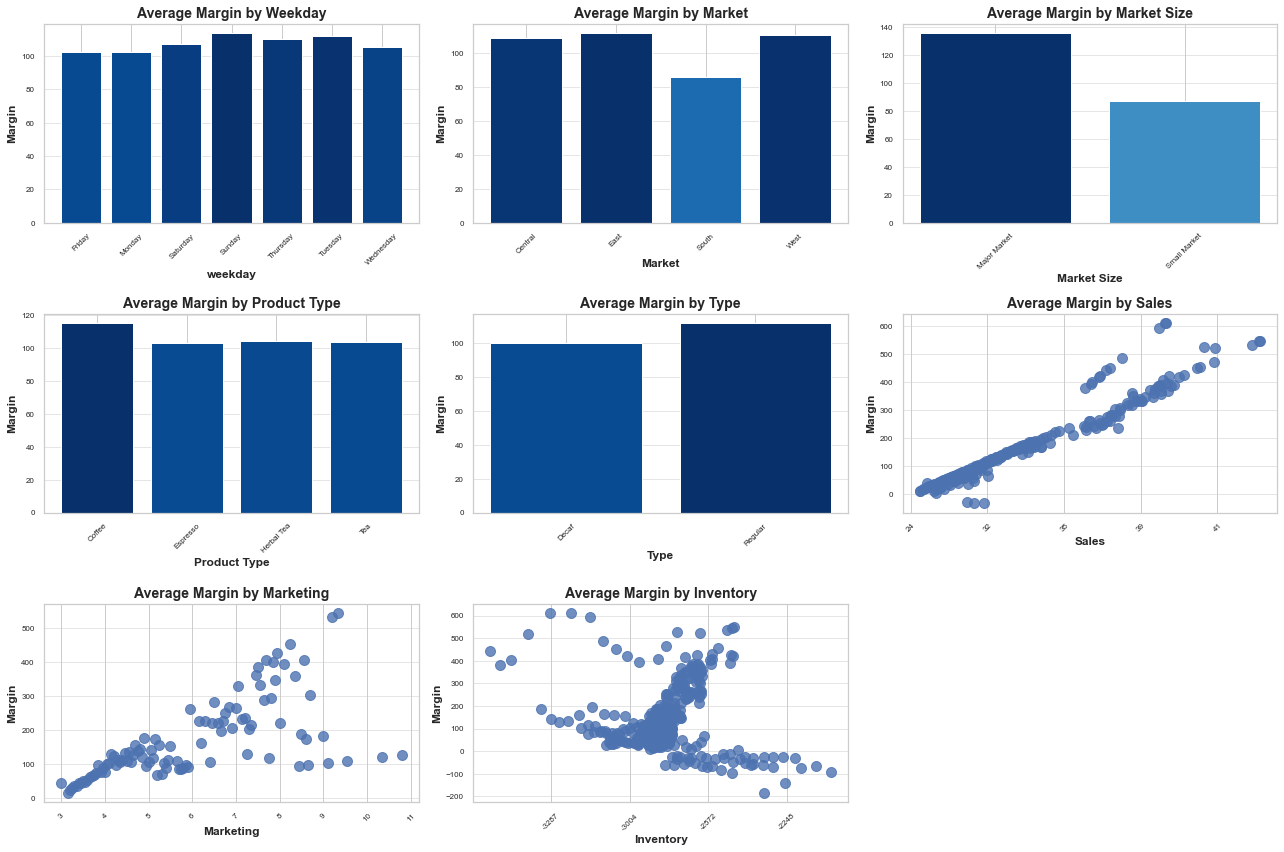

In [144]:
# Ignore all warnings
warnings.filterwarnings("ignore")

# Create a figure with 3 rows and 3 columns
fig, axes = plt.subplots(3, 3, figsize=(18, 12))

# List of categories and titles
categories = [
    ('weekday', 'Average Margin by Weekday'),
    ('Market', 'Average Margin by Market'),
    ('Market Size', 'Average Margin by Market Size'),
    ('Product Type', 'Average Margin by Product Type'),
    ('Type', 'Average Margin by Type'),
    ('Sales', 'Average Margin by Sales'),
    ('Marketing', 'Average Margin by Marketing'),
    ('Inventory', 'Average Margin by Inventory')
]

# Loop through categories to create plots
for i, (category, title) in enumerate(categories):
    row, col = divmod(i, 3)
    margin_by_category = data.groupby(category)['Margin'].mean().reset_index()
    cmap = plt.cm.get_cmap('Blues')
    colors = [cmap(j) for j in margin_by_category['Margin'] / margin_by_category['Margin'].max()]
    
    if category in ['Sales', 'Marketing', 'Inventory']:
        axes[row, col].scatter(margin_by_category[category], margin_by_category['Margin'], s=100, alpha=0.8)
    else:
        axes[row, col].bar(margin_by_category[category], margin_by_category['Margin'], color=colors)
        
    axes[row, col].set_title(title, fontsize=14, fontweight='bold')
    axes[row, col].set_xlabel(category, fontsize=12 ,fontweight='bold')
    axes[row, col].set_ylabel('Margin', fontsize=12,fontweight='bold')
    axes[row, col].tick_params(axis='both', which='major', labelsize=8)
    axes[row, col].grid(axis='y', alpha=0.5)
    axes[row, col].set_xticklabels(margin_by_category[category], rotation=45)

# Remove unused subplots
for i in range(len(categories), 3 * 3):
    row, col = divmod(i, 3)
    fig.delaxes(axes[row, col])

plt.tight_layout()
plt.show()

## making indicator variable

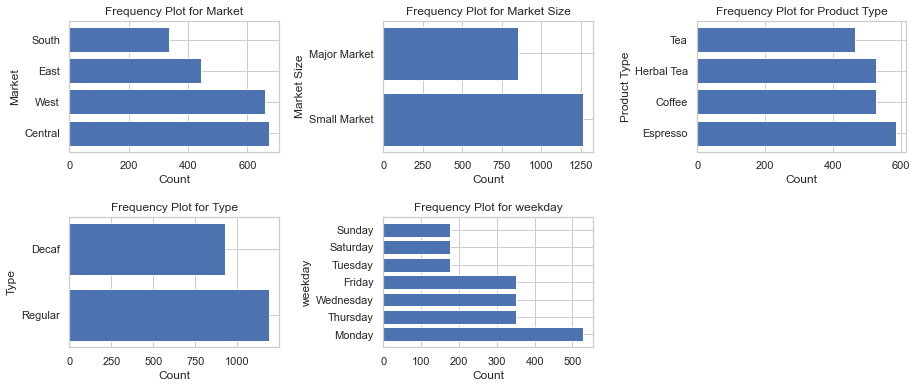

In [145]:
# making indicator variables (Choosing the most common category as baseline
non_numeric_columns = data.select_dtypes(exclude=['number']).columns

# Calculate the number of rows needed
num_rows = (len(non_numeric_columns) + 2) // 3

# Create a figure with the desired layout
fig, axes = plt.subplots(num_rows, 3, figsize=(15, 3*num_rows))

# Iterate over the non-numeric columns and plot the frequency plots
for i, column in enumerate(non_numeric_columns):
    row = i // 3
    col = i % 3
    value_counts = data[column].value_counts()
    if len(value_counts) > 0:  # Check if the column has any non-zero values
        axes[row, col].barh(value_counts.index, value_counts.values)
        axes[row, col].set_xlabel("Count")
        axes[row, col].set_ylabel(column)
        axes[row, col].set_title("Frequency Plot for " + column ,)

# Remove the extra subplot (if any)
for i in range(len(non_numeric_columns), num_rows * 3):
    row = i // 3
    col = i % 3
    fig.delaxes(axes[row, col])

# Adjust the spacing between subplots
plt.subplots_adjust(hspace=0.5, wspace=0.5)

# Show the figure
plt.show()

In [146]:
df=data
df_dummy = pd.get_dummies(df)
df_dummy

,Margin,Sales,Inventory,Marketing,Market_Central,Market_East,Market_South,Market_West,Market Size_Major Market,Market Size_Small Market,...,Product Type_Tea,Type_Decaf,Type_Regular,weekday_Friday,weekday_Monday,weekday_Saturday,weekday_Sunday,weekday_Thursday,weekday_Tuesday,weekday_Wednesday
0,176,292,962,38,0,1,0,0,0,1,...,0,0,1,0,0,0,0,1,0,0
1,135,225,1148,29,0,1,0,0,0,1,...,0,0,1,0,0,0,0,1,0,0
2,195,325,1134,42,0,1,0,0,0,1,...,0,0,1,0,1,0,0,0,0,0
3,174,289,1166,37,0,1,0,0,0,1,...,0,0,1,0,0,0,0,0,0,1
4,31,51,804,5,0,1,0,0,0,1,...,1,0,1,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2107,87,150,37,57,0,0,1,0,0,1,...,0,0,1,0,0,0,0,1,0,0
2108,90,154,-113,58,0,0,1,0,0,1,...,0,0,1,0,0,1,0,0,0,0
2109,66,113,-395,42,0,0,1,0,0,1,...,0,0,1,0,0,0,0,1,0,0
2110,61,105,-508,39,0,0,1,0,0,1,...,0,0,1,0,0,0,1,0,0,0


**In each variable, we consider the most frequent as the baseline**

In [147]:
# List of columns to drop
columns_to_drop = ['weekday_Monday', 'Type_Regular', 'Product Type_Espresso', 'Market Size_Small Market', 'Market_Central']
df_dummy = df_dummy.drop(columns=columns_to_drop)
df_dummy

,Margin,Sales,Inventory,Marketing,Market_East,Market_South,Market_West,Market Size_Major Market,Product Type_Coffee,Product Type_Herbal Tea,Product Type_Tea,Type_Decaf,weekday_Friday,weekday_Saturday,weekday_Sunday,weekday_Thursday,weekday_Tuesday,weekday_Wednesday
0,176,292,962,38,1,0,0,0,1,0,0,0,0,0,0,1,0,0
1,135,225,1148,29,1,0,0,0,1,0,0,0,0,0,0,1,0,0
2,195,325,1134,42,1,0,0,0,1,0,0,0,0,0,0,0,0,0
3,174,289,1166,37,1,0,0,0,1,0,0,0,0,0,0,0,0,1
4,31,51,804,5,1,0,0,0,0,0,1,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2107,87,150,37,57,0,1,0,0,0,0,0,0,0,0,0,1,0,0
2108,90,154,-113,58,0,1,0,0,0,0,0,0,0,1,0,0,0,0
2109,66,113,-395,42,0,1,0,0,0,0,0,0,0,0,0,1,0,0
2110,61,105,-508,39,0,1,0,0,0,0,0,0,0,0,1,0,0,0


## Building Full Model with all features(17)

In [148]:
# Fit the linear regression model
X = df_dummy.drop('Margin', axis=1) # Features
y = df_dummy['Margin'] # Target variable
X = sm.add_constant(X)

X = X.astype(np.float64)
y = y.astype(np.float64)

model_sm = sm.OLS(y, X).fit()
print(model_sm.summary())


                            OLS Regression Results                            
Dep. Variable:                 Margin   R-squared:                       0.968
Model:                            OLS   Adj. R-squared:                  0.968
Method:                 Least Squares   F-statistic:                     3767.
Date:                Tue, 23 Jul 2024   Prob (F-statistic):               0.00
Time:                        13:32:41   Log-Likelihood:                -8854.5
No. Observations:                2110   AIC:                         1.774e+04
Df Residuals:                    2092   BIC:                         1.785e+04
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

### Although R^adj is a very good number, we are looking to reduce the features



## 

## VIF - Multicolinearity 
### Values above 5 indicate multicollinearity

In [149]:
# Calculate VIF
vif = pd.DataFrame()
vif['feature'] = X.columns
vif_scores = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = vif_scores
vif['VIF'] = round(vif['VIF'], 2)
vif = vif[vif['feature'] != 'const']
vif = vif.sort_values(by='VIF', ascending=False)
print(vif)


                     feature   VIF
3                  Marketing  2.51
1                      Sales  2.40
11                Type_Decaf  2.14
9    Product Type_Herbal Tea  2.11
10          Product Type_Tea  1.69
6                Market_West  1.49
8        Product Type_Coffee  1.45
2                  Inventory  1.42
5               Market_South  1.39
12            weekday_Friday  1.39
15          weekday_Thursday  1.39
17         weekday_Wednesday  1.39
4                Market_East  1.35
7   Market Size_Major Market  1.27
14            weekday_Sunday  1.23
13          weekday_Saturday  1.22
16           weekday_Tuesday  1.22


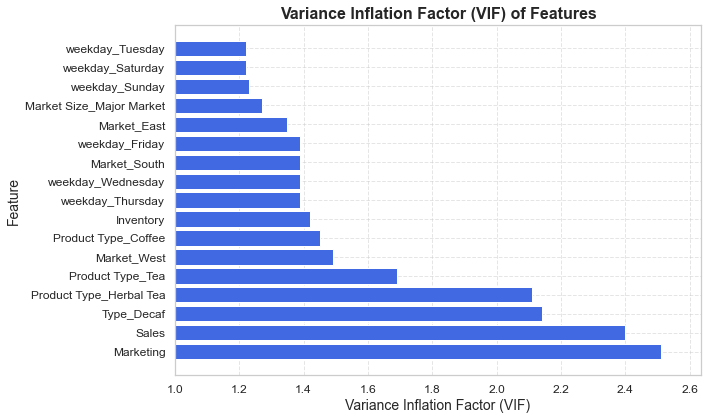

In [133]:
# VIF plot
vif = vif.sort_values(by='VIF', ascending=False)
plt.figure(figsize=(10, 6))
plt.barh(vif['feature'], vif['VIF'], color='#4169E1')
plt.xlabel('Variance Inflation Factor (VIF)', fontsize=14)
plt.ylabel('Feature', fontsize=14)
plt.title('Variance Inflation Factor (VIF) of Features', fontsize=16, fontweight='bold')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.xlim(left=1)
plt.tight_layout()
plt.show()

## Corrolation Matrix

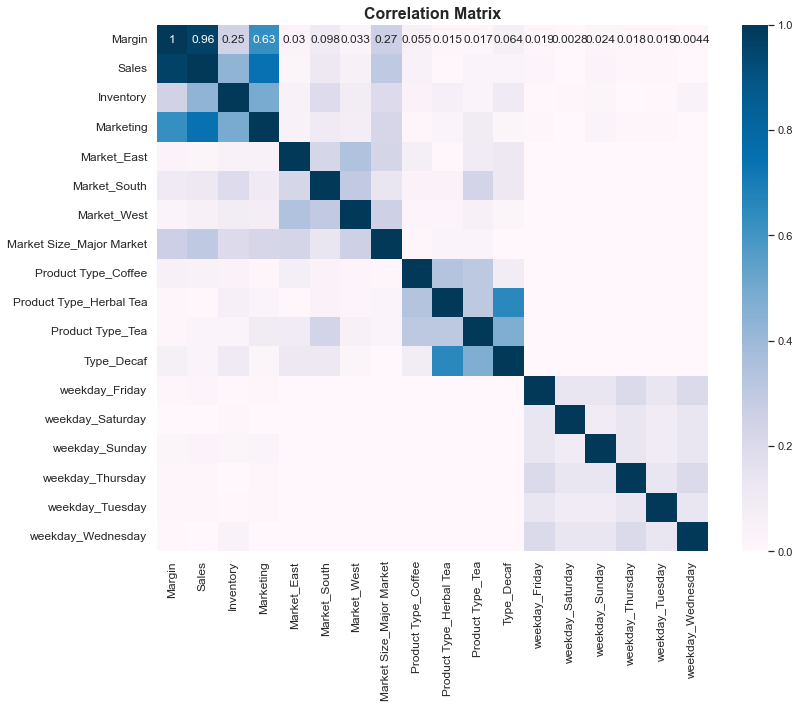

In [150]:
# Calculate the correlation matrix
corr_matrix = df_dummy.corr()

# Take the absolute value of negative correlations
corr_matrix = corr_matrix.abs()

# Create the correlation heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='PuBu', vmin=0, vmax=1)
plt.title('Correlation Matrix', fontsize=16, fontweight='bold')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

# Correlation with Margin

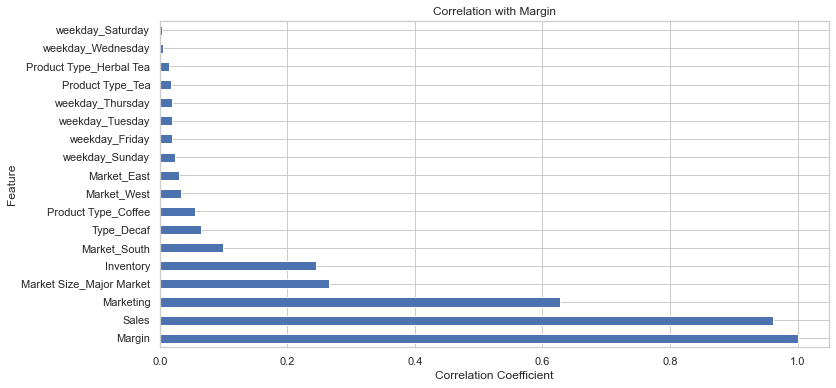

In [151]:
corr_matrix = df_dummy.corr()
corr_with_margin = corr_matrix['Margin'].abs().sort_values(ascending=False)
plt.figure(figsize=(12, 6))
corr_with_margin.plot(kind='barh')
plt.title('Correlation with Margin')
plt.ylabel('Feature')
plt.xlabel('Correlation Coefficient')
plt.show()


### We remove variables that have a correlation of less than 0.019 with margin

In [152]:
corr_matrix = df_dummy.corr()
corr_with_margin = corr_matrix['Margin'].abs().sort_values(ascending=False)
cols_to_keep = corr_with_margin[corr_with_margin >= 0.019].index
df_dummy= df_dummy[cols_to_keep]

df_dummy.columns

Index(['Margin', 'Sales', 'Marketing', 'Market Size_Major Market', 'Inventory',
       'Market_South', 'Type_Decaf', 'Product Type_Coffee', 'Market_West',
       'Market_East', 'weekday_Sunday'],
      dtype='object')

## Density plot

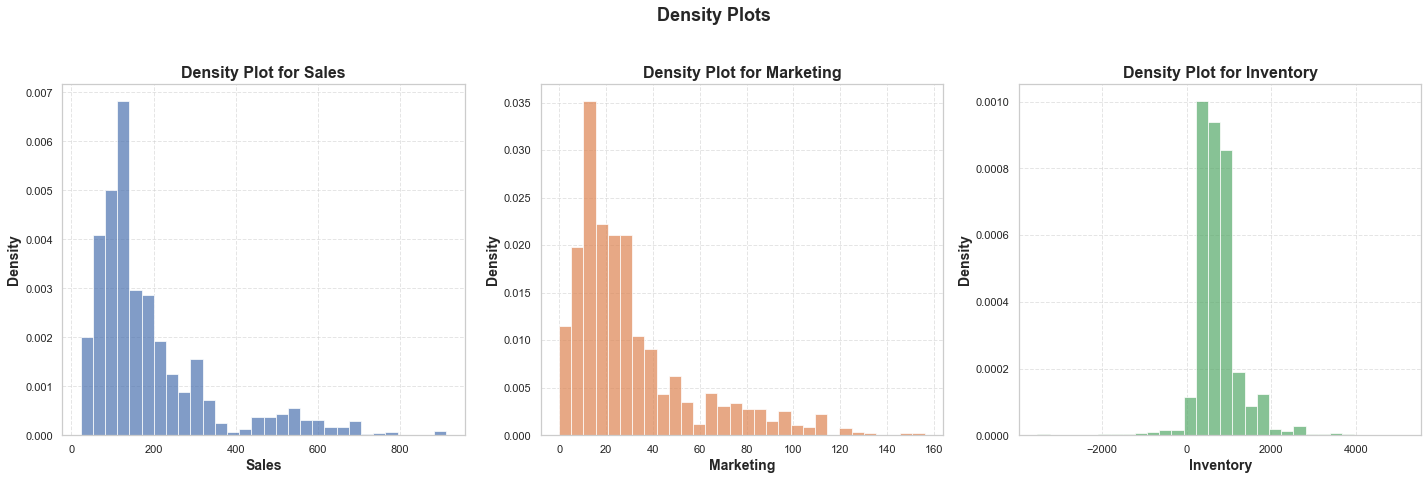

In [153]:

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 7))

# Sales Density Plot
ax1.hist(df_dummy['Sales'], bins=30, density=True, alpha=0.7, color='#4c72b0')
ax1.set_title('Density Plot for Sales', fontsize=16, fontweight='bold')
ax1.set_xlabel('Sales', fontsize=14, fontweight='bold')
ax1.set_ylabel('Density', fontsize=14, fontweight='bold')
ax1.grid(True, linestyle='--', alpha=0.5)

# Marketing Density Plot
ax2.hist(df_dummy['Marketing'], bins=30, density=True, alpha=0.7, color='#dd8452')
ax2.set_title('Density Plot for Marketing', fontsize=16, fontweight='bold')
ax2.set_xlabel('Marketing', fontsize=14, fontweight='bold')
ax2.set_ylabel('Density', fontsize=14, fontweight='bold')
ax2.grid(True, linestyle='--', alpha=0.5)

# Inventory Density Plot
ax3.hist(df_dummy['Inventory'], bins=30, density=True, alpha=0.7, color='#55a868')
ax3.set_title('Density Plot for Inventory', fontsize=16, fontweight='bold')
ax3.set_xlabel('Inventory', fontsize=14, fontweight='bold')
ax3.set_ylabel('Density', fontsize=14, fontweight='bold')
ax3.grid(True, linestyle='--', alpha=0.5)

# Improve overall layout
plt.suptitle('Density Plots', fontsize=18, fontweight='bold')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

## Building the model with the remaining features

In [154]:
X = df_dummy.drop('Margin', axis=1) # Features
y = df_dummy['Margin'] # Target variable
X = sm.add_constant(X)
X = X.astype(np.float64)
y = y.astype(np.float64)
model_sm = sm.OLS(y, X).fit()
print(model_sm.summary())

                            OLS Regression Results                            
Dep. Variable:                 Margin   R-squared:                       0.968
Model:                            OLS   Adj. R-squared:                  0.968
Method:                 Least Squares   F-statistic:                     6412.
Date:                Tue, 23 Jul 2024   Prob (F-statistic):               0.00
Time:                        13:34:31   Log-Likelihood:                -8856.7
No. Observations:                2110   AIC:                         1.774e+04
Df Residuals:                    2099   BIC:                         1.780e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

## diagnostic

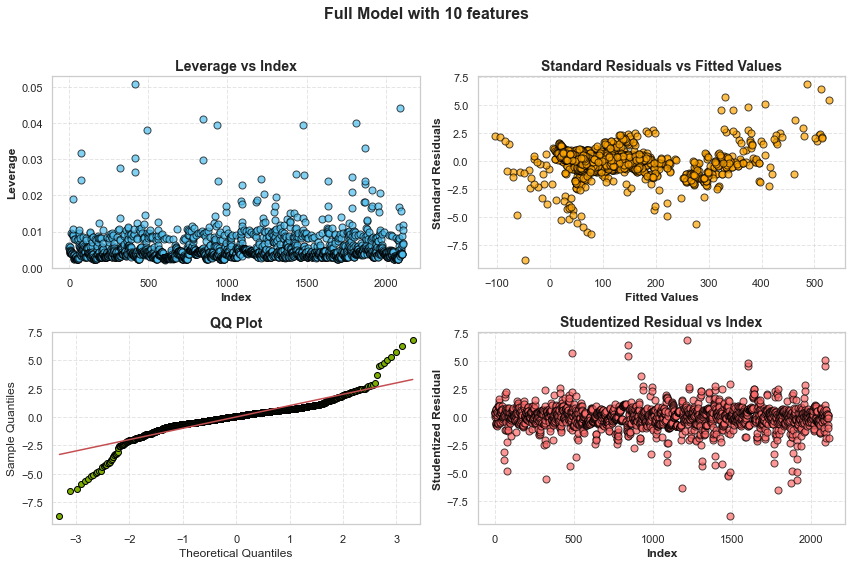

In [155]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 8))

# Leverage vs index
ax1.scatter(range(len(model_sm.get_influence().hat_matrix_diag)), model_sm.get_influence().hat_matrix_diag, s=50, alpha=0.7, edgecolor='black', facecolor='#4DBEEE')
ax1.set_xlabel('Index', fontsize=12, fontweight='bold')
ax1.set_ylabel('Leverage', fontsize=12, fontweight='bold')
ax1.set_title('Leverage vs Index', fontsize=14, fontweight='bold')
ax1.grid(True, linestyle='--', alpha=0.5)

# Standard Residuals vs Fitted Values
std_residuals = model_sm.get_influence().resid_studentized_internal
fitted_values = model_sm.fittedvalues
ax2.scatter(fitted_values, std_residuals, s=50, alpha=0.7, edgecolor='black', facecolor='#FFA500')
ax2.set_xlabel('Fitted Values', fontsize=12, fontweight='bold')
ax2.set_ylabel('Standard Residuals', fontsize=12, fontweight='bold')
ax2.set_title('Standard Residuals vs Fitted Values', fontsize=14, fontweight='bold')
ax2.grid(True, linestyle='--', alpha=0.5)

# QQ Plot
ax3.set_title('QQ Plot', fontsize=14, fontweight='bold')
sm.qqplot(model_sm.resid, line='s', fit=True, ax=ax3, marker='o', markerfacecolor='#7CAE00', markeredgecolor='black')
ax3.grid(True, linestyle='--', alpha=0.5)

# Studentized Residuals vs Index
ax4.scatter(range(len(model_sm.get_influence().resid_studentized_internal)), model_sm.get_influence().resid_studentized_internal, s=50, alpha=0.7, edgecolor='black', facecolor='#FF6B6B')
ax4.set_xlabel('Index', fontsize=12, fontweight='bold')
ax4.set_ylabel('Studentized Residual', fontsize=12, fontweight='bold')
ax4.set_title('Studentized Residual vs Index', fontsize=14, fontweight='bold')
ax4.grid(True, linestyle='--', alpha=0.5)

fig.suptitle('Full Model with 10 features', fontsize=16, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.96]) 
plt.show()

### The value of R^2 adj did not change even though the number of features decreased. But the graphs question the assumptions of normality and linearity and show the existence of outliers. Then we use transform.



## Y transform 
* ### 1/y transform

                            OLS Regression Results                            
Dep. Variable:                 Margin   R-squared:                       0.270
Model:                            OLS   Adj. R-squared:                  0.266
Method:                 Least Squares   F-statistic:                     77.49
Date:                Tue, 23 Jul 2024   Prob (F-statistic):          1.66e-135
Time:                        13:37:08   Log-Likelihood:                 6355.5
No. Observations:                2110   AIC:                        -1.269e+04
Df Residuals:                    2099   BIC:                        -1.263e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

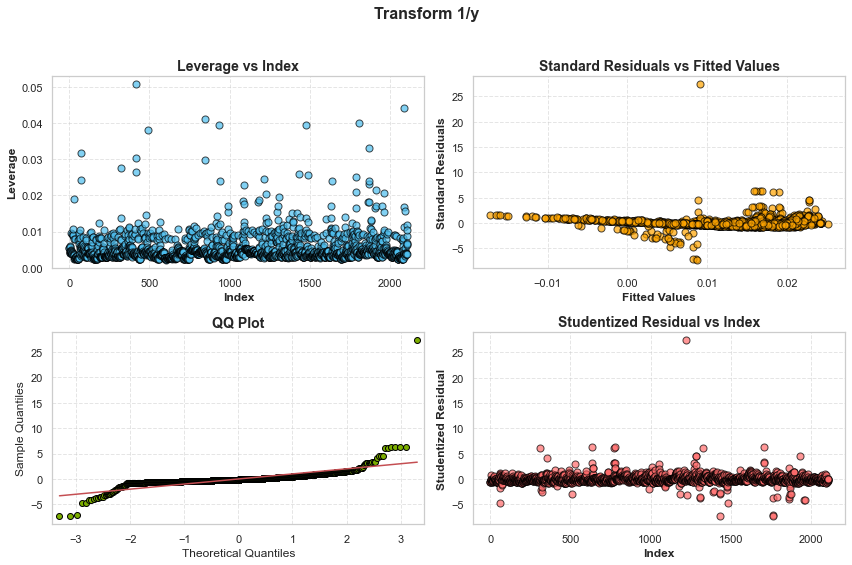

In [156]:
dd = df_dummy.copy()
dd['Margin'] = 1 / dd['Margin']

X = dd.drop('Margin', axis=1) # Features
y = dd['Margin'] # Target variable
X = sm.add_constant(X)
X = X.astype(np.float64)
y = y.astype(np.float64)
model_sm = sm.OLS(y, X).fit()
print(model_sm.summary())

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 8))

# Leverage vs index
ax1.scatter(range(len(model_sm.get_influence().hat_matrix_diag)), model_sm.get_influence().hat_matrix_diag, s=50, alpha=0.7, edgecolor='black', facecolor='#4DBEEE')
ax1.set_xlabel('Index', fontsize=12, fontweight='bold')
ax1.set_ylabel('Leverage', fontsize=12, fontweight='bold')
ax1.set_title('Leverage vs Index', fontsize=14, fontweight='bold')
ax1.grid(True, linestyle='--', alpha=0.5)

# Standard Residuals vs Fitted Values
std_residuals = model_sm.get_influence().resid_studentized_internal
fitted_values = model_sm.fittedvalues
ax2.scatter(fitted_values, std_residuals, s=50, alpha=0.7, edgecolor='black', facecolor='#FFA500')
ax2.set_xlabel('Fitted Values', fontsize=12, fontweight='bold')
ax2.set_ylabel('Standard Residuals', fontsize=12, fontweight='bold')
ax2.set_title('Standard Residuals vs Fitted Values', fontsize=14, fontweight='bold')
ax2.grid(True, linestyle='--', alpha=0.5)

# QQ Plot
ax3.set_title('QQ Plot', fontsize=14, fontweight='bold')
sm.qqplot(model_sm.resid, line='s', fit=True, ax=ax3, marker='o', markerfacecolor='#7CAE00', markeredgecolor='black')
ax3.grid(True, linestyle='--', alpha=0.5)

# Studentized Residuals vs Index
ax4.scatter(range(len(model_sm.get_influence().resid_studentized_internal)), model_sm.get_influence().resid_studentized_internal, s=50, alpha=0.7, edgecolor='black', facecolor='#FF6B6B')
ax4.set_xlabel('Index', fontsize=12, fontweight='bold')
ax4.set_ylabel('Studentized Residual', fontsize=12, fontweight='bold')
ax4.set_title('Studentized Residual vs Index', fontsize=14, fontweight='bold')
ax4.grid(True, linestyle='--', alpha=0.5)

fig.suptitle('Transform 1/y', fontsize=16, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.96]) 
plt.show()

* ### Log(y) transform

                            OLS Regression Results                            
Dep. Variable:                 Margin   R-squared:                       0.848
Model:                            OLS   Adj. R-squared:                  0.848
Method:                 Least Squares   F-statistic:                     1151.
Date:                Tue, 23 Jul 2024   Prob (F-statistic):               0.00
Time:                        11:43:56   Log-Likelihood:                -171.72
No. Observations:                2066   AIC:                             365.4
Df Residuals:                    2055   BIC:                             427.4
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

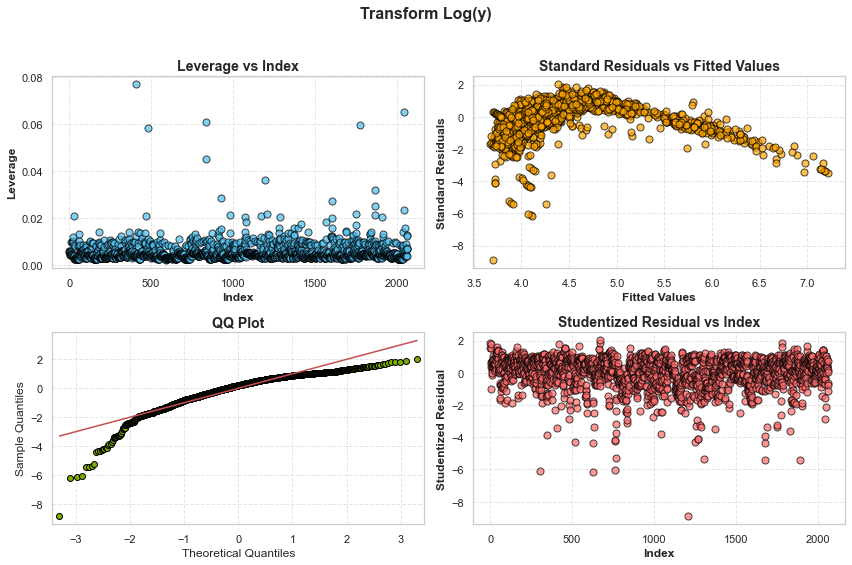

In [85]:

dd = df_dummy.copy()
mask = dd['Margin'] > 0
dd = dd[mask]
dd['Margin'] = np.log1p(dd['Margin'])

X = dd.drop('Margin', axis=1) # Features
y = dd['Margin'] # Target variable
X = sm.add_constant(X)
X = X.astype(np.float64)
y = y.astype(np.float64)
model_sm = sm.OLS(y, X).fit()
print(model_sm.summary())

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 8))

# Leverage vs index
ax1.scatter(range(len(model_sm.get_influence().hat_matrix_diag)), model_sm.get_influence().hat_matrix_diag, s=50, alpha=0.7, edgecolor='black', facecolor='#4DBEEE')
ax1.set_xlabel('Index', fontsize=12, fontweight='bold')
ax1.set_ylabel('Leverage', fontsize=12, fontweight='bold')
ax1.set_title('Leverage vs Index', fontsize=14, fontweight='bold')
ax1.grid(True, linestyle='--', alpha=0.5)

# Standard Residuals vs Fitted Values
std_residuals = model_sm.get_influence().resid_studentized_internal
fitted_values = model_sm.fittedvalues
ax2.scatter(fitted_values, std_residuals, s=50, alpha=0.7, edgecolor='black', facecolor='#FFA500')
ax2.set_xlabel('Fitted Values', fontsize=12, fontweight='bold')
ax2.set_ylabel('Standard Residuals', fontsize=12, fontweight='bold')
ax2.set_title('Standard Residuals vs Fitted Values', fontsize=14, fontweight='bold')
ax2.grid(True, linestyle='--', alpha=0.5)

# QQ Plot
ax3.set_title('QQ Plot', fontsize=14, fontweight='bold')
sm.qqplot(model_sm.resid, line='s', fit=True, ax=ax3, marker='o', markerfacecolor='#7CAE00', markeredgecolor='black')
ax3.grid(True, linestyle='--', alpha=0.5)

# Studentized Residuals vs Index
ax4.scatter(range(len(model_sm.get_influence().resid_studentized_internal)), model_sm.get_influence().resid_studentized_internal, s=50, alpha=0.7, edgecolor='black', facecolor='#FF6B6B')
ax4.set_xlabel('Index', fontsize=12, fontweight='bold')
ax4.set_ylabel('Studentized Residual', fontsize=12, fontweight='bold')
ax4.set_title('Studentized Residual vs Index', fontsize=14, fontweight='bold')
ax4.grid(True, linestyle='--', alpha=0.5)

fig.suptitle('Transform Log(y)', fontsize=16, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.96]) 
plt.show()



* ### y^2 transform

                            OLS Regression Results                            
Dep. Variable:                 Margin   R-squared:                       0.822
Model:                            OLS   Adj. R-squared:                  0.821
Method:                 Least Squares   F-statistic:                     969.5
Date:                Tue, 23 Jul 2024   Prob (F-statistic):               0.00
Time:                        11:43:59   Log-Likelihood:                -23436.
No. Observations:                2110   AIC:                         4.689e+04
Df Residuals:                    2099   BIC:                         4.696e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

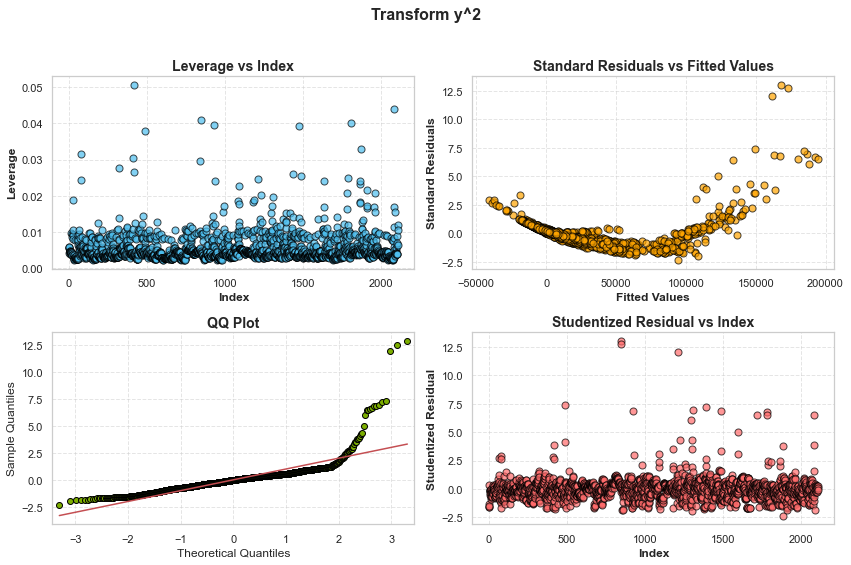

In [86]:

dd = df_dummy.copy()
dd['Margin'] = dd['Margin']**2

X = dd.drop('Margin', axis=1) # Features
y = dd['Margin'] # Target variable
X = sm.add_constant(X)
X = X.astype(np.float64)
y = y.astype(np.float64)
model_sm = sm.OLS(y, X).fit()
print(model_sm.summary())


fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 8))

# Leverage vs index
ax1.scatter(range(len(model_sm.get_influence().hat_matrix_diag)), model_sm.get_influence().hat_matrix_diag, s=50, alpha=0.7, edgecolor='black', facecolor='#4DBEEE')
ax1.set_xlabel('Index', fontsize=12, fontweight='bold')
ax1.set_ylabel('Leverage', fontsize=12, fontweight='bold')
ax1.set_title('Leverage vs Index', fontsize=14, fontweight='bold')
ax1.grid(True, linestyle='--', alpha=0.5)

# Standard Residuals vs Fitted Values
std_residuals = model_sm.get_influence().resid_studentized_internal
fitted_values = model_sm.fittedvalues
ax2.scatter(fitted_values, std_residuals, s=50, alpha=0.7, edgecolor='black', facecolor='#FFA500')
ax2.set_xlabel('Fitted Values', fontsize=12, fontweight='bold')
ax2.set_ylabel('Standard Residuals', fontsize=12, fontweight='bold')
ax2.set_title('Standard Residuals vs Fitted Values', fontsize=14, fontweight='bold')
ax2.grid(True, linestyle='--', alpha=0.5)

# QQ Plot
ax3.set_title('QQ Plot', fontsize=14, fontweight='bold')
sm.qqplot(model_sm.resid, line='s', fit=True, ax=ax3, marker='o', markerfacecolor='#7CAE00', markeredgecolor='black')
ax3.grid(True, linestyle='--', alpha=0.5)

# Studentized Residuals vs Index
ax4.scatter(range(len(model_sm.get_influence().resid_studentized_internal)), model_sm.get_influence().resid_studentized_internal, s=50, alpha=0.7, edgecolor='black', facecolor='#FF6B6B')
ax4.set_xlabel('Index', fontsize=12, fontweight='bold')
ax4.set_ylabel('Studentized Residual', fontsize=12, fontweight='bold')
ax4.set_title('Studentized Residual vs Index', fontsize=14, fontweight='bold')
ax4.grid(True, linestyle='--', alpha=0.5)

fig.suptitle('Transform y^2', fontsize=16, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.96]) 
plt.show()



# X transform
### Three non-binary variables are used

* ### X^2 transform

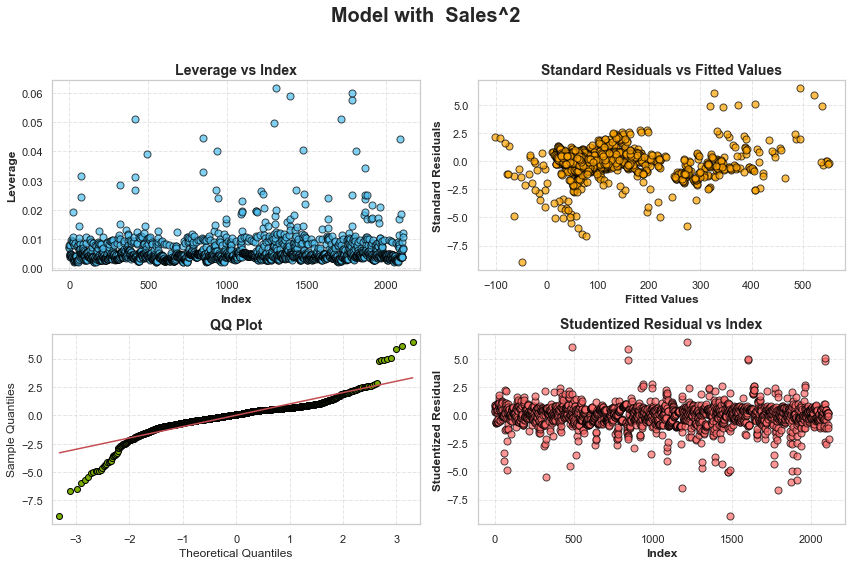

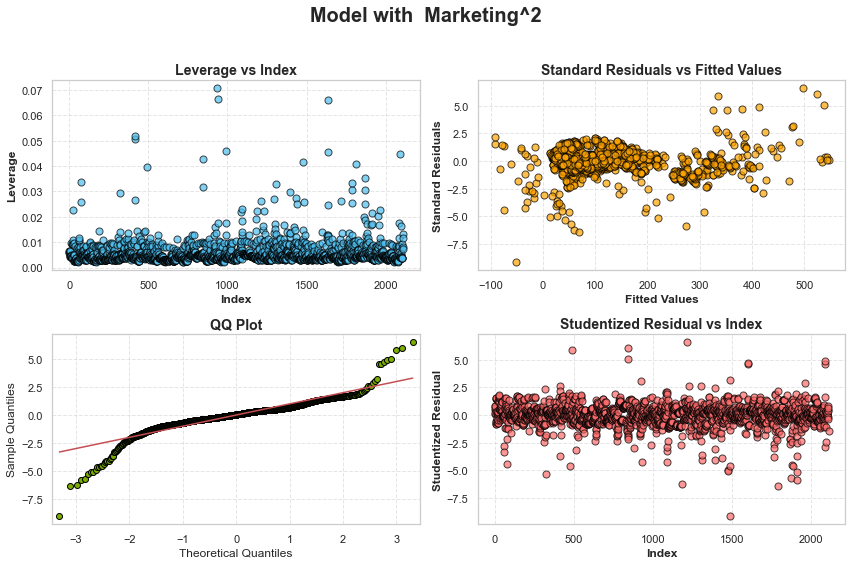

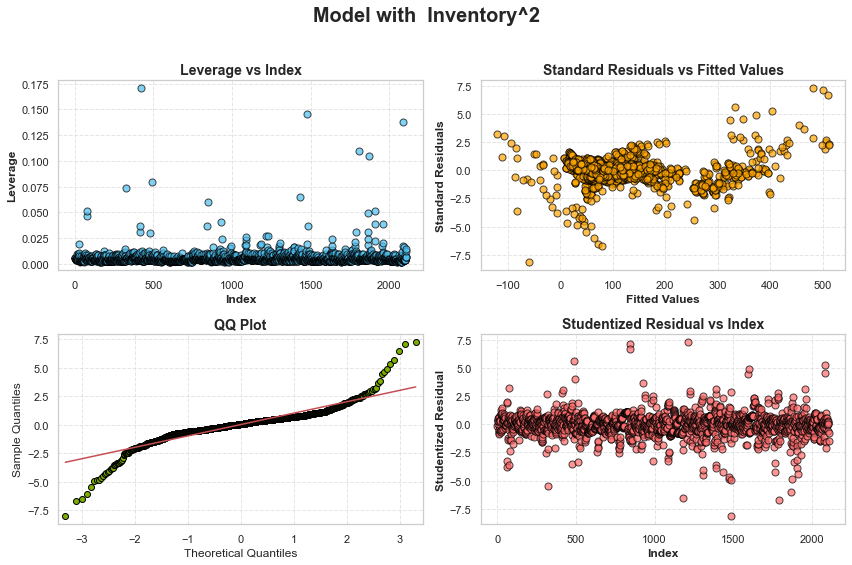

In [89]:

dd = df_dummy.copy()

for col in ['Sales', 'Marketing', 'Inventory']:
    dd = df_dummy.copy() 
    dd[f'{col}_squared'] = dd[col] ** 2
    X = dd.drop('Margin', axis=1) # Features
    y = dd['Margin'] # Target variable
    X = sm.add_constant(X)
    X = X.astype(np.float64)
    y = y.astype(np.float64)
    model_sm = sm.OLS(y, X).fit()

    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 8))
    
    # Leverage vs index
    ax1.scatter(range(len(model_sm.get_influence().hat_matrix_diag)), model_sm.get_influence().hat_matrix_diag, s=50, alpha=0.7, edgecolor='black', facecolor='#4DBEEE')
    ax1.set_xlabel('Index', fontsize=12, fontweight='bold')
    ax1.set_ylabel('Leverage', fontsize=12, fontweight='bold')
    ax1.set_title('Leverage vs Index', fontsize=14, fontweight='bold')
    ax1.grid(True, linestyle='--', alpha=0.5)
    
    # Standard Residuals vs Fitted Values
    std_residuals = model_sm.get_influence().resid_studentized_internal
    fitted_values = model_sm.fittedvalues
    ax2.scatter(fitted_values, std_residuals, s=50, alpha=0.7, edgecolor='black', facecolor='#FFA500')
    ax2.set_xlabel('Fitted Values', fontsize=12, fontweight='bold')
    ax2.set_ylabel('Standard Residuals', fontsize=12, fontweight='bold')
    ax2.set_title('Standard Residuals vs Fitted Values', fontsize=14, fontweight='bold')
    ax2.grid(True, linestyle='--', alpha=0.5)
    
    # QQ Plot
    ax3.set_title('QQ Plot', fontsize=14, fontweight='bold')
    sm.qqplot(model_sm.resid, line='s', fit=True, ax=ax3, marker='o', markerfacecolor='#7CAE00', markeredgecolor='black')
    ax3.grid(True, linestyle='--', alpha=0.5)
    
    # Studentized Residuals vs Index
    ax4.scatter(range(len(model_sm.get_influence().resid_studentized_internal)), model_sm.get_influence().resid_studentized_internal, s=50, alpha=0.7, edgecolor='black', facecolor='#FF6B6B')
    ax4.set_xlabel('Index', fontsize=12, fontweight='bold')
    ax4.set_ylabel('Studentized Residual', fontsize=12, fontweight='bold')
    ax4.set_title('Studentized Residual vs Index', fontsize=14, fontweight='bold')
    ax4.grid(True, linestyle='--', alpha=0.5)
    
    fig.suptitle(f'Model with  {col}^2', fontsize=20, fontweight='bold')
    plt.tight_layout(rect=[0, 0, 1, 0.96]) 
    plt.show()
    
    
    

* ### X^3 transform

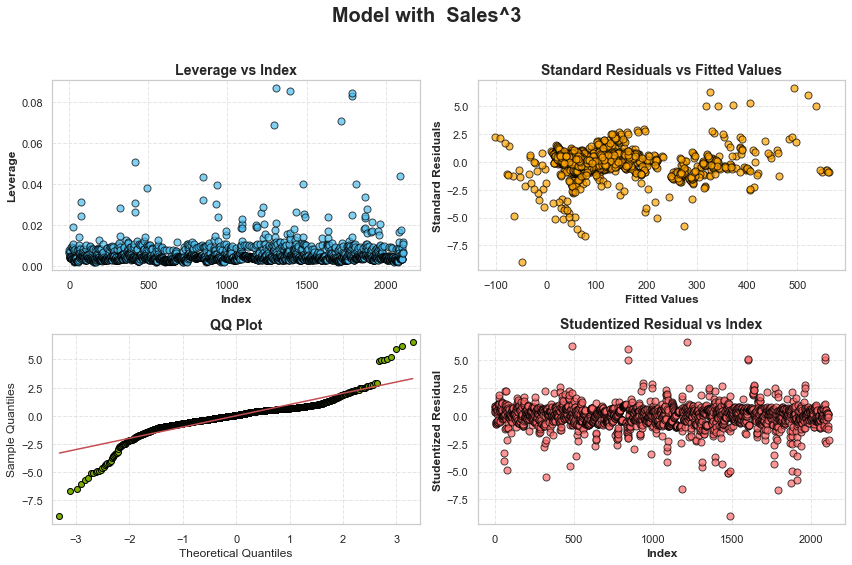

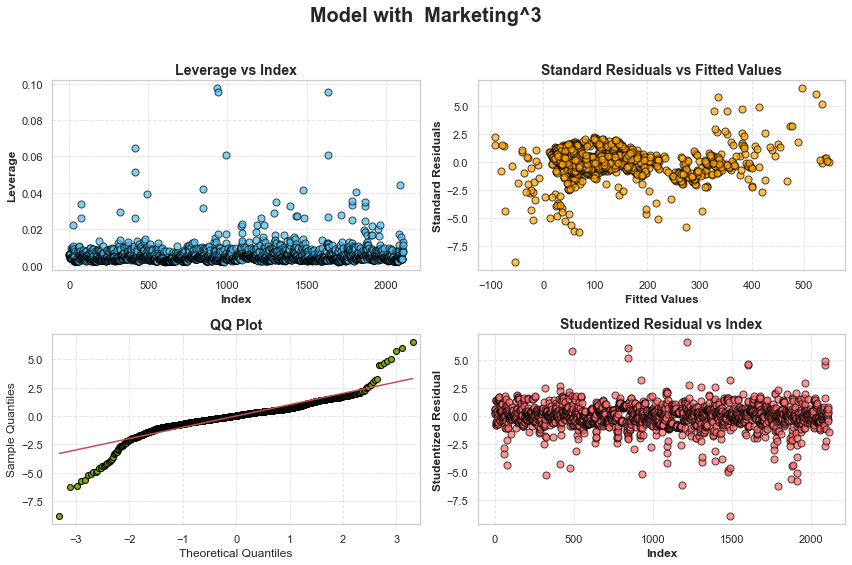

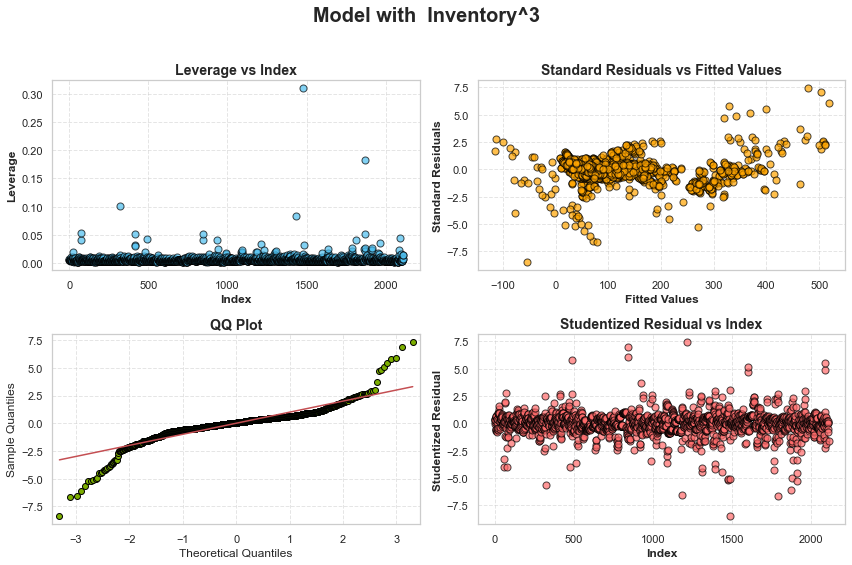

In [90]:
dd = df_dummy.copy()

for col in ['Sales', 'Marketing', 'Inventory']:
    dd = df_dummy.copy() 
    dd[f'{col}_squared'] = dd[col] ** 3
    X = dd.drop('Margin', axis=1) # Features
    y = dd['Margin'] # Target variable
    X = sm.add_constant(X)
    X = X.astype(np.float64)
    y = y.astype(np.float64)
    model_sm = sm.OLS(y, X).fit()

    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 8))
    
    # Leverage vs index
    ax1.scatter(range(len(model_sm.get_influence().hat_matrix_diag)), model_sm.get_influence().hat_matrix_diag, s=50, alpha=0.7, edgecolor='black', facecolor='#4DBEEE')
    ax1.set_xlabel('Index', fontsize=12, fontweight='bold')
    ax1.set_ylabel('Leverage', fontsize=12, fontweight='bold')
    ax1.set_title('Leverage vs Index', fontsize=14, fontweight='bold')
    ax1.grid(True, linestyle='--', alpha=0.5)
    
    # Standard Residuals vs Fitted Values
    std_residuals = model_sm.get_influence().resid_studentized_internal
    fitted_values = model_sm.fittedvalues
    ax2.scatter(fitted_values, std_residuals, s=50, alpha=0.7, edgecolor='black', facecolor='#FFA500')
    ax2.set_xlabel('Fitted Values', fontsize=12, fontweight='bold')
    ax2.set_ylabel('Standard Residuals', fontsize=12, fontweight='bold')
    ax2.set_title('Standard Residuals vs Fitted Values', fontsize=14, fontweight='bold')
    ax2.grid(True, linestyle='--', alpha=0.5)
    
    # QQ Plot
    ax3.set_title('QQ Plot', fontsize=14, fontweight='bold')
    sm.qqplot(model_sm.resid, line='s', fit=True, ax=ax3, marker='o', markerfacecolor='#7CAE00', markeredgecolor='black')
    ax3.grid(True, linestyle='--', alpha=0.5)
    
    # Studentized Residuals vs Index
    ax4.scatter(range(len(model_sm.get_influence().resid_studentized_internal)), model_sm.get_influence().resid_studentized_internal, s=50, alpha=0.7, edgecolor='black', facecolor='#FF6B6B')
    ax4.set_xlabel('Index', fontsize=12, fontweight='bold')
    ax4.set_ylabel('Studentized Residual', fontsize=12, fontweight='bold')
    ax4.set_title('Studentized Residual vs Index', fontsize=14, fontweight='bold')
    ax4.grid(True, linestyle='--', alpha=0.5)
    
    fig.suptitle(f'Model with  {col}^3', fontsize=20, fontweight='bold')
    plt.tight_layout(rect=[0, 0, 1, 0.96]) 
    plt.show()

* ### Xi * Xj transform

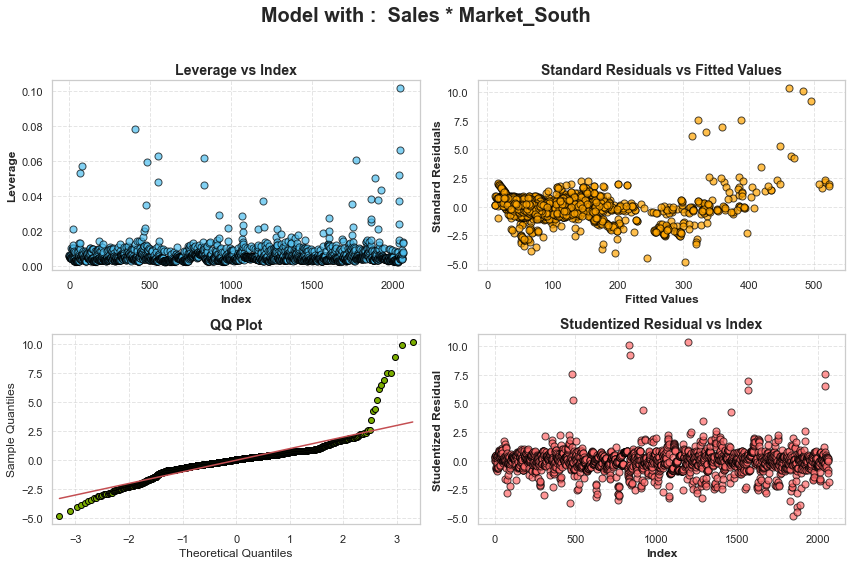

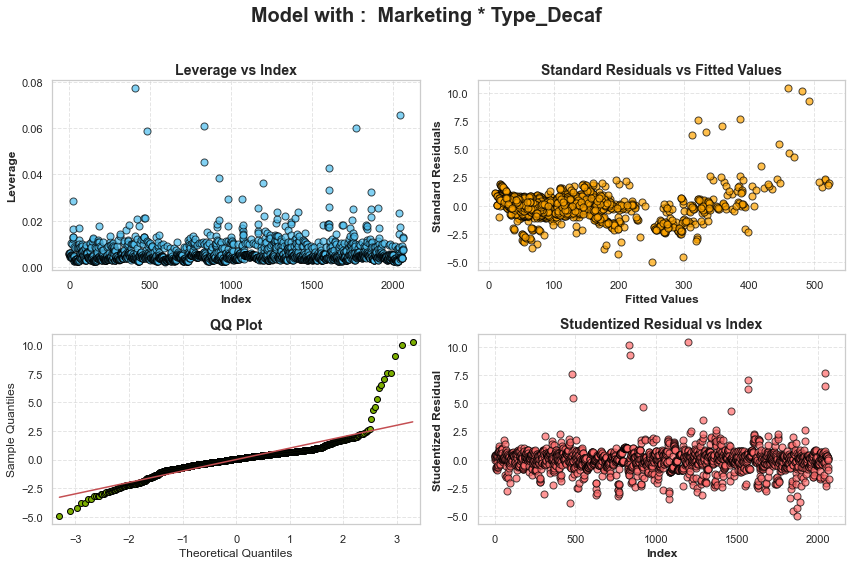

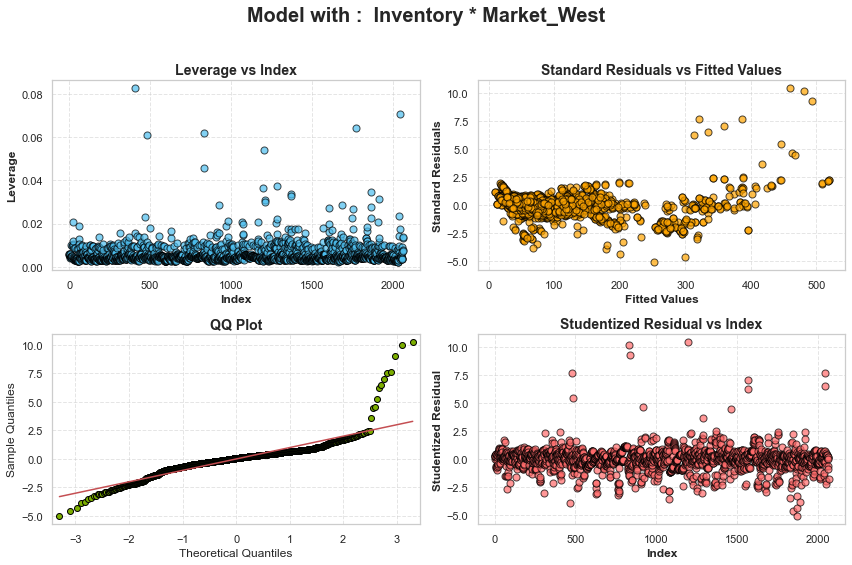

In [95]:

dd = df_dummy.copy()
mask = dd['Margin'] > 0
dd = dd[mask]

for col, col2 in [('Sales', 'Market_South'), ('Marketing', 'Type_Decaf'), ('Inventory', 'Market_West')]:
    dd_temp = dd.copy()
    dd_temp[f'{col}_{col2}_squared'] = dd_temp[col] * dd_temp[col2]
    X = dd_temp.drop('Margin', axis=1)
    y = dd_temp['Margin']
    X = sm.add_constant(X)
    X = X.astype(np.float64)
    y = y.astype(np.float64)
    model_sm = sm.OLS(y, X).fit()

    # Create a new figure with 2x2 subplots
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 8))
    
    # Leverage vs index
    ax1.scatter(range(len(model_sm.get_influence().hat_matrix_diag)), model_sm.get_influence().hat_matrix_diag, s=50, alpha=0.7, edgecolor='black', facecolor='#4DBEEE')
    ax1.set_xlabel('Index', fontsize=12, fontweight='bold')
    ax1.set_ylabel('Leverage', fontsize=12, fontweight='bold')
    ax1.set_title('Leverage vs Index', fontsize=14, fontweight='bold')
    ax1.grid(True, linestyle='--', alpha=0.5)
    
    # Standard Residuals vs Fitted Values
    std_residuals = model_sm.get_influence().resid_studentized_internal
    fitted_values = model_sm.fittedvalues
    ax2.scatter(fitted_values, std_residuals, s=50, alpha=0.7, edgecolor='black', facecolor='#FFA500')
    ax2.set_xlabel('Fitted Values', fontsize=12, fontweight='bold')
    ax2.set_ylabel('Standard Residuals', fontsize=12, fontweight='bold')
    ax2.set_title('Standard Residuals vs Fitted Values', fontsize=14, fontweight='bold')
    ax2.grid(True, linestyle='--', alpha=0.5)
    
    # QQ Plot
    sm.qqplot(model_sm.resid, line='s', fit=True, ax=ax3, marker='o', markerfacecolor='#7CAE00', markeredgecolor='black')
    ax3.set_title('QQ Plot', fontsize=14, fontweight='bold')
    ax3.grid(True, linestyle='--', alpha=0.5)
    
    # Studentized Residuals vs Index
    ax4.scatter(range(len(model_sm.get_influence().resid_studentized_internal)), model_sm.get_influence().resid_studentized_internal, s=50, alpha=0.7, edgecolor='black', facecolor='#FF6B6B')
    ax4.set_xlabel('Index', fontsize=12, fontweight='bold')
    ax4.set_ylabel('Studentized Residual', fontsize=12, fontweight='bold')
    ax4.set_title('Studentized Residual vs Index', fontsize=14, fontweight='bold')
    ax4.grid(True, linestyle='--', alpha=0.5)
    
    fig.suptitle(f'Model with :  {col} * {col2}', fontsize=20, fontweight='bold')
    plt.tight_layout(rect=[0, 0, 1, 0.96]) 
    plt.show()
    

### None of the transformations improved the condition of the graphs. So let's use robust. That is, we do not use constant variance to calculate betas

## 

## Robust

In [96]:
X = df_dummy.drop('Margin', axis=1) # Features
y = df_dummy['Margin'] # Target variable
X = sm.add_constant(X)

X = X.astype(np.float64)
y = y.astype(np.float64)
auto_mod = sm.OLS(y, X).fit()

coeftest = auto_mod.get_robustcov_results(cov_type='HC1').summary()
print(coeftest)


                            OLS Regression Results                            
Dep. Variable:                 Margin   R-squared:                       0.968
Model:                            OLS   Adj. R-squared:                  0.968
Method:                 Least Squares   F-statistic:                     3409.
Date:                Tue, 23 Jul 2024   Prob (F-statistic):               0.00
Time:                        11:48:22   Log-Likelihood:                -8856.7
No. Observations:                2110   AIC:                         1.774e+04
Df Residuals:                    2099   BIC:                         1.780e+04
Df Model:                          10                                         
Covariance Type:                  HC1                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

## ANOVA

                                sum_sq      df             F         PR(>F)
Sales                     9.378075e+06     1.0  36010.899932   0.000000e+00
Marketing                 1.200134e+05     1.0    460.839794   1.396408e-92
Market_Size_Major_Market  7.893392e+03     1.0     30.309861   4.133156e-08
Inventory                 4.035537e+05     1.0   1549.607148  2.668169e-254
Market_South              4.592211e+03     1.0     17.633644   2.789974e-05
Type_Decaf                4.092076e+02     1.0      1.571317   2.101554e-01
Product_Type_Coffee       4.007456e+03     1.0     15.388244   9.034508e-05
Market_West               5.055983e+02     1.0      1.941449   1.636589e-01
Market_East               2.722804e+03     1.0     10.455304   1.241952e-03
weekday_Sunday            4.101560e+00     1.0      0.015750   9.001418e-01
Residual                  5.466284e+05  2099.0           NaN            NaN


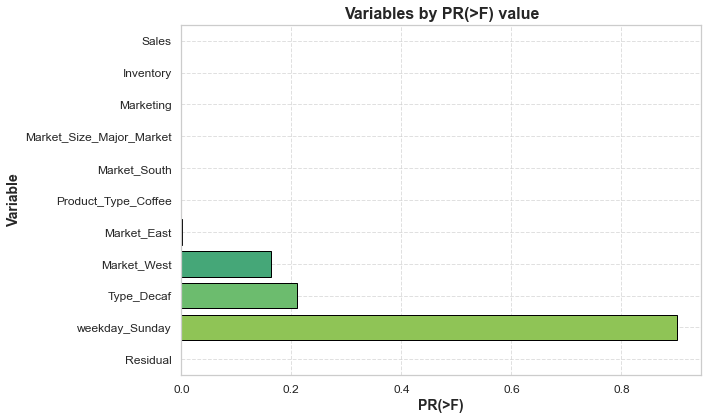

In [98]:
df_dummy = df_dummy.rename(columns=lambda x: x.replace(' ', '_'))
model = ols(' Margin ~ Sales + Marketing + Market_Size_Major_Market + Inventory + Market_South + Type_Decaf + Product_Type_Coffee + Market_West + Market_East + weekday_Sunday ', data=df_dummy).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)

# plot
anova_table = anova_table.sort_values('PR(>F)')
anova_df = anova_table.reset_index()
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='PR(>F)', y='index', data=anova_df, palette='viridis', edgecolor='black')
ax.set_title('Variables by PR(>F) value', fontsize=16, fontweight='bold')
ax.set_xlabel('PR(>F)', fontsize=14, fontweight='bold')
ax.set_ylabel('Variable', fontsize=14, fontweight='bold')
ax.grid(True, linestyle='--', alpha=0.6)
ax.tick_params(axis='both', which='major', labelsize=12)
plt.tight_layout()
plt.show()

### The variables weekday_Sunday and Type_Decaf have the lowest PR(>F) values, indicating the highest statistical significance, while variables like Sales, Inventory, and Marketing have relatively higher PR(>F) values suggesting weaker relationships with the dependent variable.

### 

## All regression coefficients are equal?

In [99]:
coefficients = model_sm.params
mean_coefficient = np.mean(coefficients)

ss_between = np.sum((coefficients - mean_coefficient)**2)
ss_within = np.sum((coefficients - np.mean(coefficients))**2)
df_between = len(coefficients) - 1
df_within = len(coefficients) * (len(coefficients) - 1)

f_statistic = (ss_between / df_between) / (ss_within / df_within)
p_value = 1 - f.cdf(f_statistic, df_between, df_within)
print ("All regression coefficients are equal?")
print("F-statistic:", f_statistic)
print("p-value:", p_value)


All regression coefficients are equal?
F-statistic: 12.0
p-value: 2.220446049250313e-15


### Because of the low p_value, the null hypothesis is rejected

### 

## All regression coefficients are equal to zero?

In [100]:

residuals = model_sm.resid
rss = np.sum(residuals**2)

df_model = len(model_sm.params) - 1
df_residual = len(residuals)

f_statistic = (np.sum((model_sm.fittedvalues)**2) / df_model) / (rss / df_residual)
p_value = 1 - f.cdf(f_statistic, df_model, df_residual)
print ("All regression coefficients are equal to zero?")
print("F-statistic:", f_statistic)
print("p-value:", p_value)

All regression coefficients are equal to zero?
F-statistic: 21032.383696083303
p-value: 1.1102230246251565e-16


### Because of the low p_value, the null hypothesis is rejected

### 

## finding best model (forward selection method) 

In [102]:
lr = LinearRegression()
sfs = SFS(lr,
          k_features='best',  # 'best' will select the best number of features automatically
          forward=True,
          floating=False,
          scoring='neg_mean_squared_error',
          cv=5)

sfs = sfs.fit(X, y)
selected_feature_indices = sfs.k_feature_idx_
selected_feature_names = [X.columns[i] for i in selected_feature_indices]
print("Selected feature indices:", selected_feature_indices)
print("Selected feature names:", selected_feature_names)

lr.fit(X[selected_feature_names], y)
lr = sm.OLS(y, X[selected_feature_names]).fit()
print(lr.summary())

Selected feature indices: (1, 2, 3, 4, 5, 7, 9)
Selected feature names: ['Sales', 'Marketing', 'Market Size_Major Market', 'Inventory', 'Market_South', 'Product Type_Coffee', 'Market_East']
                                 OLS Regression Results                                
Dep. Variable:                 Margin   R-squared (uncentered):                   0.986
Model:                            OLS   Adj. R-squared (uncentered):              0.986
Method:                 Least Squares   F-statistic:                          2.060e+04
Date:                Tue, 23 Jul 2024   Prob (F-statistic):                        0.00
Time:                        11:49:25   Log-Likelihood:                         -8939.9
No. Observations:                2110   AIC:                                  1.789e+04
Df Residuals:                    2103   BIC:                                  1.793e+04
Df Model:                           7                                                  
Covariance Type:  

## finding best model (backward selection method)

In [103]:
def backward_selection(X, y, significance_level=0.05):
    # Fit initial model with all features
    model = sm.OLS(y, sm.add_constant(X)).fit()
    selected_features = list(X.columns)
    prev_r_squared = model.rsquared_adj

    while True:
        worst_feature = None
        for feat in selected_features:
            remaining_features = [f for f in selected_features if f != feat]
            X_subset = X[remaining_features]
            model = sm.OLS(y, sm.add_constant(X_subset)).fit()
            r_squared = model.rsquared_adj
            if r_squared > prev_r_squared:
                prev_r_squared = r_squared
                worst_feature = feat

        if worst_feature is not None:
            selected_features.remove(worst_feature)
        else:
            break

    final_model = sm.OLS(y, sm.add_constant(X[selected_features])).fit()

    return final_model, selected_features

final_model, selected_features = backward_selection(X, y)

print("Selected Features:", selected_features)
print(final_model.summary())


Selected Features: ['const', 'Sales', 'Marketing', 'Market Size_Major Market', 'Inventory', 'Market_South', 'Type_Decaf', 'Product Type_Coffee', 'Market_West', 'Market_East']
                            OLS Regression Results                            
Dep. Variable:                 Margin   R-squared:                       0.968
Model:                            OLS   Adj. R-squared:                  0.968
Method:                 Least Squares   F-statistic:                     7128.
Date:                Tue, 23 Jul 2024   Prob (F-statistic):               0.00
Time:                        11:49:35   Log-Likelihood:                -8856.7
No. Observations:                2110   AIC:                         1.773e+04
Df Residuals:                    2100   BIC:                         1.779e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                               coef

## 

## Conclusion
### The best model with minimum number of features and high R^2adj was obtained from the forward selection method

In [159]:
#Extract coefficients and intercept
coefficients = lr.params
intercept = coefficients[0]
features_coefficients = coefficients[1:]

#Display the equation
equation = f"y = {intercept:.4f}"
for feature, coef in zip(selected_feature_names, features_coefficients):
    equation += f" + ({coef:.4f} * {feature})"


print("The equation of the obtained model:")
print(equation)

The equation of the obtained model:
y = 0.7068 + (-0.4352 * Sales) + (-2.5104 * Marketing) + (-0.0256 * Market Size_Major Market) + (0.9340 * Inventory) + (5.9777 * Market_South) + (7.0273 * Product Type_Coffee)
